/home/darkcover/Documentos/Out/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Época 1/25 - Precisão: 1.9994, Acurácia Direcional: 3.9621, Acurácia Direcional Ponderada: 5.9615
Época 2/25 - Precisão: 2.0150, Acurácia Direcional: 3.9609, Acurácia Direcional Ponderada: 5.9759
Época 3/25 - Precisão: 2.0233, Acurácia Direcional: 3.9611, Acurácia Direcional Ponderada: 5.9844
Época 4/25 - Precisão: 2.0295, Acurácia Direcional: 3.9611, Acurácia Direcional Ponderada: 5.9905
Época 5/25 - Precisão: 1.9912, Acurácia Direcional: 3.9622, Acurácia Direcional Ponderada: 5.9534
Época 6/25 - Precisão: 1.9535, Acurácia Direcional: 3.9625, Acurácia Direcional Ponderada: 5.9160
Época 7/25 - Precisão: 2.0324, Acurácia Direcional: 3.9607, Acurácia Direcional Ponderada: 5.9931
Época 8/25 - Precisão: 2.0586, Acurácia Direcional: 3.9618, Acurácia Direcional Ponderada: 6.0203
Época 9/25 - Precisão: 2.0343, Acurácia Direcional: 3.9627, Acurácia Direcional Ponderada: 5.9970
Época 10/25 - Precisão: 2.0187, Acurácia Direcional: 3.9617, Acurácia Direcional Ponderada: 5.9803
Época 11/25 - Preci

2024-06-09 14:12:03.515454: W tensorflow/core/data/root_dataset.cc:350] Optimization loop failed: CANCELLED: Operation was cancelled


Época 24/25 - Precisão: 1.9445, Acurácia Direcional: 3.9613, Acurácia Direcional Ponderada: 5.9058
Época 25/25 - Precisão: 2.1103, Acurácia Direcional: 3.9573, Acurácia Direcional Ponderada: 6.0676


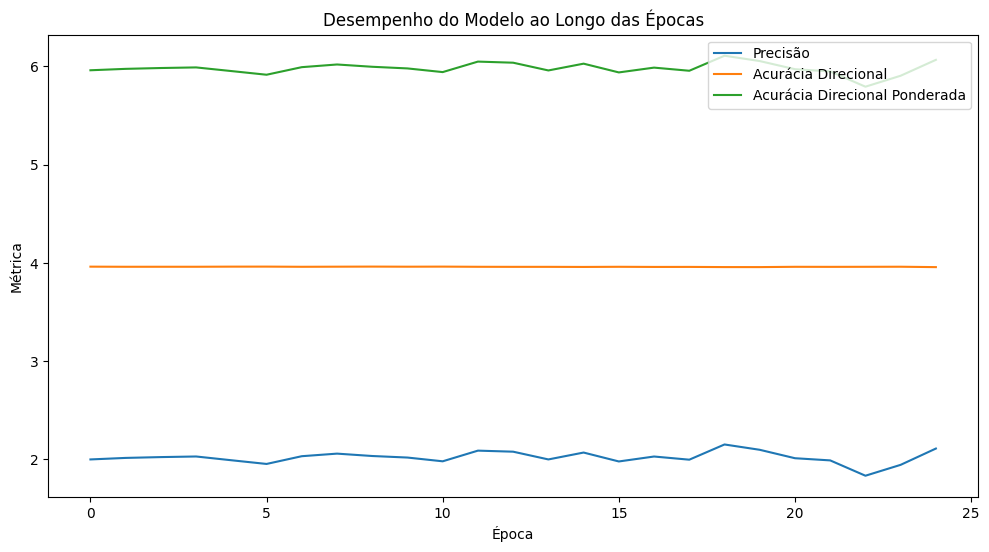

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, n_states, n_actions, learning_rate=0.001, gamma=0.99, epsilon=1.0, buffer_size=10000):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.memory = deque(maxlen=buffer_size)

        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_dim=self.n_states, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.n_actions, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.n_actions)
        q_values = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state.reshape(1, -1), batch_size=1, verbose=0)[0]))
            target_f = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def calculate_reward(action, acerto):
    if action == 1:
        if acerto == 1:
            return 10
        elif acerto == 2:
            return -5
    return 0

def normalize_data(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def main():
    data = pd.read_csv('/home/darkcover/Documentos/Out/dados/data_final.csv')
    features = data[['odd_entrada', 'media5', 'media10', 'media20', 'media40', 'media80', 'media160', 'media320', 'media640', 'level', 'contagem']].values
    rewards = data['apostar'].values
    features = normalize_data(features)

    X_train, X_test, y_train, y_test = train_test_split(features, rewards, test_size=0.2, random_state=42)

    n_epochs = 25
    batch_size = 128

    n_states = X_train.shape[1]
    n_actions = 2
    dqn_agent = DQNAgent(n_states, n_actions)

    epoch_accuracies = []
    epoch_directional_accuracies = []
    epoch_weighted_directional_accuracies = []

    for epoch in range(n_epochs):
        correct_predictions = 0
        overestimations = 0
        weighted_correct_predictions = 0
        weighted_overestimations = 0

        for i in range(len(X_train) - 1):
            state = X_train[i]
            action = dqn_agent.get_action(state)
            true_action = y_train[i]
            acerto = state[-3]
            reward = calculate_reward(action, acerto)
            next_state = X_train[i + 1]
            done = (i == len(X_train) - 2)

            dqn_agent.remember(state, action, reward, next_state, done)
            if done:
                dqn_agent.replay(batch_size)

            if action == true_action:
                correct_predictions += 1
                weighted_correct_predictions += 2
            elif action > true_action:
                overestimations += 1
                weighted_overestimations += 1

        epoch_accuracy = correct_predictions / len(X_test)
        epoch_directional_accuracy = (correct_predictions + overestimations) / len(X_test)
        epoch_weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

        epoch_accuracies.append(epoch_accuracy)
        epoch_directional_accuracies.append(epoch_directional_accuracy)
        epoch_weighted_directional_accuracies.append(epoch_weighted_directional_accuracy)

        print(f'Época {epoch + 1}/{n_epochs} - Precisão: {epoch_accuracy:.4f}, Acurácia Direcional: {epoch_directional_accuracy:.4f}, Acurácia Direcional Ponderada: {epoch_weighted_directional_accuracy:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(epoch_accuracies, label='Precisão')
    plt.plot(epoch_directional_accuracies, label='Acurácia Direcional')
    plt.plot(epoch_weighted_directional_accuracies, label='Acurácia Direcional Ponderada')
    plt.xlabel('Época')
    plt.ylabel('Métrica')
    plt.legend()
    plt.title('Desempenho do Modelo ao Longo das Épocas')
    plt.show()

if __name__ == "__main__":
    main()


Época 1/25 - Precisão: 2.0032, Acurácia Direcional: 3.9625, Acurácia Direcional Ponderada: 5.9656
Época 2/25 - Precisão: 2.0105, Acurácia Direcional: 3.9619, Acurácia Direcional Ponderada: 5.9723
Época 3/25 - Precisão: 1.9992, Acurácia Direcional: 3.9619, Acurácia Direcional Ponderada: 5.9612
Época 4/25 - Precisão: 1.9898, Acurácia Direcional: 3.9616, Acurácia Direcional Ponderada: 5.9514
Época 5/25 - Precisão: 1.9927, Acurácia Direcional: 3.9618, Acurácia Direcional Ponderada: 5.9545
Época 6/25 - Precisão: 1.9907, Acurácia Direcional: 3.9636, Acurácia Direcional Ponderada: 5.9544
Época 7/25 - Precisão: 1.9816, Acurácia Direcional: 3.9628, Acurácia Direcional Ponderada: 5.9444
Época 8/25 - Precisão: 1.9978, Acurácia Direcional: 3.9615, Acurácia Direcional Ponderada: 5.9593
Época 9/25 - Precisão: 1.9835, Acurácia Direcional: 3.9628, Acurácia Direcional Ponderada: 5.9464
Época 10/25 - Precisão: 1.9737, Acurácia Direcional: 3.9628, Acurácia Direcional Ponderada: 5.9365
Época 11/25 - Preci

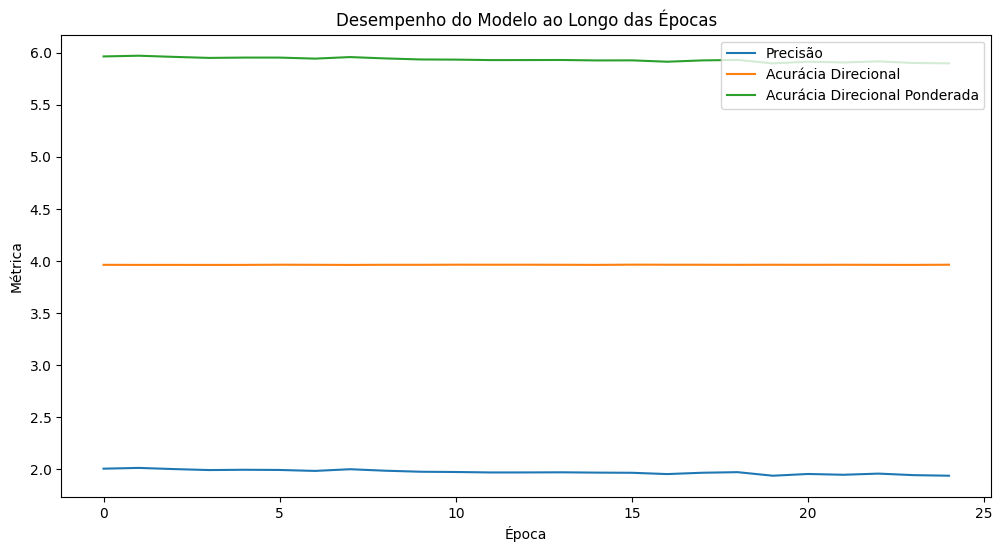

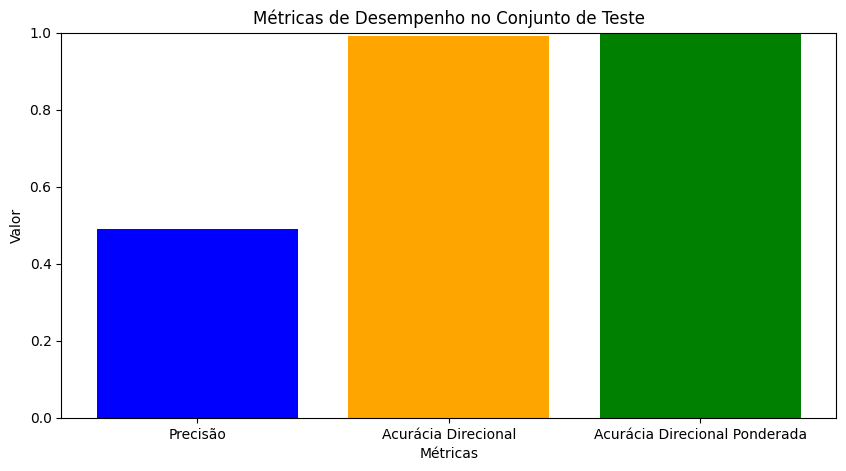

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

class DQNAgent:
    def __init__(self, n_states, n_actions, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, buffer_size=10000):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = deque(maxlen=buffer_size)
        self.model = self.build_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=tf.keras.losses.Huber())

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(self.n_states,)),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.n_actions, activation='linear')
        ])
        return model

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            q_values = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state.reshape(1, -1), batch_size=1, verbose=0))
            target_f = self.model.predict(state.reshape(1, -1), batch_size=1, verbose=0)
            target_f[0][action] = target
            self.model.fit(state.reshape(1, -1), target_f, epochs=1, verbose=0)

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def calculate_reward(action, acerto):
    reward = 0
    if action == 1:  # Apostou
        if acerto == 1:
            reward = 1  # Recompensa por apostar corretamente
        elif acerto == 2:
            reward = -2  # Penalidade por apostar incorretamente
    return reward

def normalize_data(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def main():
    # Carregar os dados
    data = pd.read_csv('/home/darkcover/Documentos/Out/dados/data_final.csv')

    # Selecionar as features e a variável de saída
    features = data[['odd_entrada', 'media5', 'media10', 'media20', 'media40', 'media80', 'media160', 'media320', 'media640']].values
    actions = data['apostar'].values  # Variável de saída: se deve apostar ou não
    acertos = data[['acerto', 'level', 'contagem']].values  # Variável de saída para calcular a recompensa

    features = normalize_data(features)

    # Adicionar level e contagem às features
    features = np.hstack((features, acertos[:, 1:]))

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test, acerto_train, acerto_test = train_test_split(features, actions, acertos, test_size=0.2, random_state=42)

    # Parâmetros de treinamento
    n_epochs = 25
    batch_size = 128

    # Crie o agente DQN
    n_states = X_train.shape[1]
    n_actions = 2  # Ações possíveis: apostar ou não apostar
    dqn_agent = DQNAgent(n_states, n_actions, learning_rate=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000)

    epoch_accuracies = []
    epoch_directional_accuracies = []
    epoch_weighted_directional_accuracies = []

    # Treinamento do agente
    for epoch in range(n_epochs):
        correct_predictions = 0
        overestimations = 0
        weighted_correct_predictions = 0
        weighted_overestimations = 0

        for i in range(len(X_train) - 1):
            state = X_train[i, :]
            action = dqn_agent.get_action(state)
            true_action = y_train[i]
            acerto = acerto_train[i][0]
            reward = calculate_reward(action, acerto)
            next_state = X_train[i + 1, :]
            done = (i == len(X_train) - 2)

            dqn_agent.remember(state, action, reward, next_state, done)

            if done:
                dqn_agent.replay(batch_size)
                dqn_agent.update_epsilon()

            if action == true_action:
                correct_predictions += 1
                weighted_correct_predictions += 2  # Peso maior para acertos exatos
            elif action > true_action:
                overestimations += 1
                weighted_overestimations += 1  # Peso menor para erros

        epoch_accuracy = correct_predictions / len(X_test)
        epoch_directional_accuracy = (correct_predictions + overestimations) / len(X_test)
        epoch_weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

        epoch_accuracies.append(epoch_accuracy)
        epoch_directional_accuracies.append(epoch_directional_accuracy)
        epoch_weighted_directional_accuracies.append(epoch_weighted_directional_accuracy)

        print(f'Época {epoch + 1}/{n_epochs} - Precisão: {epoch_accuracy:.4f}, Acurácia Direcional: {epoch_directional_accuracy:.4f}, Acurácia Direcional Ponderada: {epoch_weighted_directional_accuracy:.4f}')

    # Teste o agente
    correct_predictions = 0
    overestimations = 0
    weighted_correct_predictions = 0
    weighted_overestimations = 0

    predicted_actions = []

    for i in range(len(X_test)):
        state = X_test[i, :]
        action = dqn_agent.get_action(state)
        true_action = y_test[i]

        predicted_actions.append(action)

        if action == true_action:
            correct_predictions += 1
            weighted_correct_predictions += 2
        elif action > true_action:
            overestimations += 1
            weighted_overestimations += 1

    accuracy = correct_predictions / len(X_test)
    directional_accuracy = (correct_predictions + overestimations) / len(X_test)
    weighted_directional_accuracy = (weighted_correct_predictions + weighted_overestimations) / len(X_test)

    print("Precisão:", accuracy)
    print("Acurácia Direcional:", directional_accuracy)
    print("Acurácia Direcional Ponderada:", weighted_directional_accuracy)

    plt.figure(figsize=(12, 6))
    plt.plot(epoch_accuracies, label='Precisão')
    plt.plot(epoch_directional_accuracies, label='Acurácia Direcional')
    plt.plot(epoch_weighted_directional_accuracies, label='Acurácia Direcional Ponderada')
    plt.xlabel('Época')
    plt.ylabel('Métrica')
    plt.title('Desempenho do Modelo ao Longo das Épocas')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    metrics = [accuracy, directional_accuracy, weighted_directional_accuracy]
    metric_labels = ['Precisão', 'Acurácia Direcional', 'Acurácia Direcional Ponderada']
    colors = ['blue', 'orange', 'green']
    plt.bar(metric_labels, metrics, color=colors)
    plt.xlabel('Métricas')
    plt.ylabel('Valor')
    plt.title('Métricas de Desempenho no Conjunto de Teste')
    plt.ylim(0, 1)
    plt.show()

    dqn_agent.model.save('AgenteAposta.h5')
    data_save = pd.DataFrame({'epoch_accuracies': epoch_accuracies,
                              'epoch_directional_accuracies': epoch_directional_accuracies,
                              'epoch_weighted_directional_accuracies': epoch_weighted_directional_accuracies})
    data_save.to_csv('/home/darkcover/Documentos/Out/dados/metricas_aposta.csv', index=False)

if __name__ == '__main__':
    main()
